In [1]:
import numpy as np
import torch as nn
from torch.autograd import grad
import matplotlib.pyplot as plt

In [2]:
def getGrid(m, T):
    x = nn.linspace(-1, 1, m, dtype = nn.float, requires_grad = True).reshape(m, 1, 1, 1).repeat(1, m, m, 1)
    y = nn.linspace(-1, 1, m, dtype = nn.float, requires_grad = True).reshape(1, m, 1, 1).repeat(m, 1, m, 1)
    t = nn.linspace(0, T, m, dtype = nn.float, requires_grad = True).reshape(1, 1, m, 1).repeat(m, m, 1, 1)
    return nn.cat((x, y, t), dim = -1)

In [3]:
def getDPT(m, T):
    x = nn.linspace(-1, 1, m, dtype = nn.float, requires_grad = True)
    y = nn.linspace(-1, 1, m, dtype = nn.float, requires_grad = True)
    t = nn.linspace(0, T, m, dtype = nn.float, requires_grad = True)
    X, Y, T = nn.meshgrid(x, y, t, indexing = 'ij')
    X1, Y1, T1 = X.flatten()[:, None], Y.flatten()[:, None], T.flatten()[:, None]
    return nn.cat((X1, Y1, T1), 1)

In [87]:
getDPT(8,1)

tensor([[-1.0000, -1.0000,  0.0000],
        [-1.0000, -1.0000,  0.1429],
        [-1.0000, -1.0000,  0.2857],
        ...,
        [ 1.0000,  1.0000,  0.7143],
        [ 1.0000,  1.0000,  0.8571],
        [ 1.0000,  1.0000,  1.0000]], grad_fn=<CatBackward0>)

In [4]:
def gD(y, x, n):
    if n == 0:
        return y
    else:
        dy_dx = grad(y, x, nn.ones_like(y), create_graph=True, retain_graph=True, allow_unused=True)[0]
        return gD(dy_dx, x, n - 1)

In [5]:
def build_model(hidden_dimension, activation):
    modules=[]
    modules.append(nn.nn.Linear(3, hidden_dimension[0]))
    modules.append(activation)
    for i in range(len(hidden_dimension)-2):
        modules.append(nn.nn.Linear(hidden_dimension[i], hidden_dimension[i+1]))
        modules.append(activation)
    modules.append(nn.nn.Linear(hidden_dimension[len(hidden_dimension)-2], hidden_dimension[len(hidden_dimension)-1]))
    modules.append(nn.nn.Linear(hidden_dimension[-1], 1))
    #modules.append(activation)
    model = nn.nn.Sequential(*modules)
    return model

In [45]:
class PINN_solver:
    
    def __init__(self, dta_dim, mdl_dim, eps, gma, activation):
        self.dta = getDPT(dta_dim[0], dta_dim[1])
        self.dta_loss = getGrid(dta_dim[0], dta_dim[1])
        self.model_phi = build_model(mdl_dim, activation)
        self.model_psi = build_model(mdl_dim, activation)
        self.alpha = -0.5
        self.lbd = 1
        self.g = 0        
        self.eps = eps
        self.gma = gma
        self.df_loss = None
        self.bc_loss = None
        self.tm_loss = None
        self.tl_loss = None
        self.optimizer_phi = None
        self.optimizer_psi = None
        
    def get_disp_phi(self, x, y, t):
        return self.model_phi(nn.cat((x, y, t), 1))
    
    def get_disp_psi(self, x, y, t):
        return self.model_psi(nn.cat((x, y, t), 1))
    
    def costFn(self):
        x, y, t = self.dta[:, 0][:, None], self.dta[:, 1][:, None], self.dta[:, 2][:, None]
        phi, psi = self.get_disp_phi(x, y, t), self.get_disp_psi(x, y, t)
        df_loss = 0
        df_loss += (gD(phi,t,1) - (gD(phi,x,2) - gD(phi,y,2)) - self.alpha * phi \
                 - phi*phi*phi + self.eps*phi*psi)**2
        
        df_loss += (gD(psi,t,1) + 2*self.lbd*(gD(psi,x,2) + gD(psi,y,2)) + \
                   self.lbd*(gD(psi,x,4) + gD(psi,y,4)) + (self.gma + self.lbd)*(psi) - \
                   self.g*(psi*psi) + psi*psi*psi + self.eps*phi*phi/2)**2
        
        df_loss = nn.sum(df_loss**2).view(1)

        bc_loss = 0
        lhs_dpts = self.dta_loss[0, :, :].reshape((-1, 3))
        btm_dpts = self.dta_loss[:, 0, :].reshape((-1, 3))
        rhs_dpts = self.dta_loss[-1, :, :].reshape((-1, 3))
        top_dpts = self.dta_loss[:, -1, :].reshape((-1, 3))
        
        x_lhs, y_lhs, t_lhs = lhs_dpts[:, 0][:, None], lhs_dpts[:, 1][:, None], lhs_dpts[:, 2][:, None]
        x_rhs, y_rhs, t_rhs = rhs_dpts[:, 0][:, None], rhs_dpts[:, 1][:, None], rhs_dpts[:, 2][:, None]
        x_top, y_top, t_top = top_dpts[:, 0][:, None], top_dpts[:, 1][:, None], top_dpts[:, 2][:, None]
        x_btm, y_btm, t_btm = btm_dpts[:, 0][:, None], btm_dpts[:, 1][:, None], btm_dpts[:, 2][:, None]
        
        bc_loss += (self.get_disp_phi(x_lhs, y_lhs, t_lhs) - self.get_disp_phi(x_rhs, y_rhs, t_rhs))**2
        bc_loss += (self.get_disp_phi(x_top, y_top, t_top) - self.get_disp_phi(x_btm, y_btm, t_btm))**2
        bc_loss += (self.get_disp_psi(x_lhs, y_lhs, t_lhs) - self.get_disp_psi(x_rhs, y_rhs, t_rhs))**2
        bc_loss += (self.get_disp_psi(x_top, y_top, t_top) - self.get_disp_psi(x_btm, y_btm, t_btm))**2
        bc_loss = nn.sum(bc_loss).view(1)

        tm_loss = 0
        tm_dpt = self.dta_loss[:, :, 0].reshape((-1, 3))
        x, y, t = tm_dpt[:, 0][:, None], tm_dpt[:, 1][:, None], tm_dpt[:, 2][:, None]
        #nr_dtb = nn.randn(tm_dpt.shape[0])[:, None]
        tm_dpt_phi = self.get_disp_phi(x, y, t)
        tm_dpt_psi = self.get_disp_psi(x, y, t)
        #tm_loss += 5e-4*(nn.sum((tm_dpt_phi - nr_dtb)**2 + (tm_dpt_psi - nr_dtb)**2)).view(1)
        tm_loss += (tm_dpt_phi.sum())**2 + ((tm_dpt_psi).sum())**2
        #normal_dist = (1/(2*np.pi*0.1))*(nn.exp(-((x**2)/0.1 + (y**2)/0.1)))
        #tm_loss += ((tm_dpt_phi - normal_dist)**2).sum() + ((tm_dpt_psi - normal_dist)**2).sum() 
        #tm_loss *= 10e-4
        return df_loss, bc_loss, tm_loss
    
    def closure(self):
        self.optimizer_phi.zero_grad()
        self.optimizer_psi.zero_grad()
        loss = self.costFn()
        loss = loss[0] + loss[1] + loss[2]
        loss.backward(retain_graph = True)
        return loss
    
    def train(self, epochs, **kwargs): 
        self.optimizer_phi = nn.optim.LBFGS(self.model_phi.parameters(), **kwargs)
        self.optimizer_psi = nn.optim.LBFGS(self.model_psi.parameters(), **kwargs)
        
        self.df_loss = np.zeros(epochs)
        self.bc_loss = np.zeros(epochs)
        self.tm_loss = np.zeros(epochs)
        self.tl_loss = np.zeros(epochs)
        
        for i in range(epochs): 
            df_loss, bc_loss, tm_loss = self.costFn()
            tl_loss = df_loss + bc_loss + tm_loss
            self.df_loss[i] = df_loss
            self.bc_loss[i] = bc_loss
            self.tm_loss[i] = tm_loss
            self.tl_loss[i] = tl_loss
            self.printLoss(i, epochs)
            self.optimizer_phi.step(self.closure)
            self.optimizer_psi.step(self.closure)
            

    def printLoss(self, epoch, epochs, print_every = 5):
        if epoch % print_every == 0:
            print("Eqn Loss = " + str(self.df_loss[epoch]) + " BC Loss = " + str(self.bc_loss[epoch]) + \
                  " IC Loss = " + str(self.tm_loss[epoch]) + " Total Loss = " + str(self.tl_loss[epoch]))

In [84]:
pinnModel = PINN_solver([8, 1], [32,32,32], -1.5,  -1.5, nn.nn.Tanh())

In [85]:
a1 = pinnModel.train(50)

Eqn Loss = 1.0895664691925049 BC Loss = 3.501828670501709 IC Loss = 136.20855712890625 Total Loss = 140.79995727539062
Eqn Loss = 4.368637746665627e-06 BC Loss = 3.8721231248928234e-05 IC Loss = 2.686087263725767e-08 Total Loss = 4.311672819312662e-05
Eqn Loss = 2.3623286438123614e-07 BC Loss = 8.971388524514623e-06 IC Loss = 1.1646624997752042e-08 Total Loss = 9.21926857699873e-06
Eqn Loss = 2.4492905481565685e-07 BC Loss = 8.930033800425008e-06 IC Loss = 2.849713867658643e-11 Total Loss = 9.174990736937616e-06
Eqn Loss = 2.4492905481565685e-07 BC Loss = 8.930033800425008e-06 IC Loss = 2.849713867658643e-11 Total Loss = 9.174990736937616e-06
Eqn Loss = 2.4492905481565685e-07 BC Loss = 8.930033800425008e-06 IC Loss = 2.849713867658643e-11 Total Loss = 9.174990736937616e-06
Eqn Loss = 2.4492905481565685e-07 BC Loss = 8.930033800425008e-06 IC Loss = 2.849713867658643e-11 Total Loss = 9.174990736937616e-06
Eqn Loss = 2.4492905481565685e-07 BC Loss = 8.930033800425008e-06 IC Loss = 2.84971

In [79]:
def plotData(model): 
    x = getDPT(8, 1)
    m = int(np.cbrt(x.shape[0]))
    phi, psi = model.get_disp_phi(x[:, 0][:, None], x[:, 1][:, None], x[:, 2][:, None]), model.get_disp_psi(x[:, 0][:, None], x[:, 1][:, None], x[:, 2][:, None])
    phi, psi = nn.squeeze(phi), nn.squeeze(psi)
    phi, psi = phi[1::m].reshape((m, m)), psi[1::m].reshape((m, m))
    print(phi.shape)
    print(psi)
    phi_p, psi_p = nn.where(phi > 0, 1, 0), nn.where(psi > 0, 1, 0)
    plt.imshow(phi_p.cpu(), cmap='Greys',  interpolation='nearest')
    plt.show()
    plt.imshow(psi_p.cpu(), cmap='Greys',  interpolation='nearest')    
    plt.show()

torch.Size([12, 12])
tensor([[ 1.5447e-04,  6.6070e-04,  1.0341e-03,  1.2752e-03,  1.3902e-03,
          1.3906e-03,  1.2936e-03,  1.1200e-03,  8.9331e-04,  6.3752e-04,
          3.7546e-04,  1.2682e-04],
        [-1.3787e-04,  3.8153e-04,  7.6651e-04,  1.0172e-03,  1.1393e-03,
          1.1445e-03,  1.0500e-03,  8.7723e-04,  6.5059e-04,  3.9499e-04,
          1.3424e-04, -1.1103e-04],
        [-3.6865e-04,  1.6233e-04,  5.5720e-04,  8.1556e-04,  9.4287e-04,
          9.5074e-04,  8.5653e-04,  6.8236e-04,  4.5328e-04,  1.9532e-04,
         -6.6719e-05, -3.1123e-04],
        [-5.2976e-04,  1.0294e-05,  4.1266e-04,  6.7649e-04,  8.0685e-04,
          8.1535e-04,  7.1944e-04,  5.4176e-04,  3.0808e-04,  4.5398e-05,
         -2.2057e-04, -4.6725e-04],
        [-6.1889e-04, -7.3417e-05,  3.3314e-04,  5.9959e-04,  7.3085e-04,
          7.3829e-04,  6.3951e-04,  4.5730e-04,  2.1795e-04, -5.0998e-05,
         -3.2297e-04, -5.7462e-04],
        [-6.3833e-04, -9.2062e-05,  3.1461e-04,  5.8051e-04

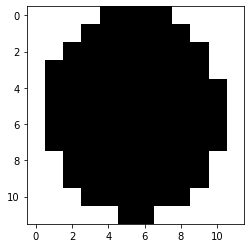

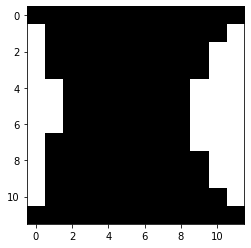

In [86]:
plotData(pinnModel)